## Creating Adversarial Examples Using a basic iterative method
This notebook is part of Module 3 of the [ODSC Europe 2021](https://odsc.com/europe/) workshop [Adversarial Attacks and Defence in Computer Vision 101](https://odsc.com/speakers/adversarial-attacks-and-defence-in-computer-vision-101/).  
![ODSC Logo](https://opendatascience.com/wp-content/uploads/2021/01/odsceutop.png)  
The method used is a basic iterative. The attack is performed to a [Inception V3](https://paperswithcode.com/method/inception-v3) model trained on [ImageNet](https://www.image-net.org/).  
This notebook can be executed in a CPU runtime with good performance. No need to connect it to a GPU or TPU runtime.

### Preparation
Import all the necessary Python dependencies first. The [Keras](https://keras.io/) API in [TensorFlow](https://www.tensorflow.org/) 2 will be used. [Matplotlib](https://matplotlib.org/) is used for images display. [Plotly](https://plotly.com/python/getting-started/#overview) is used for charts.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import save_img
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Download the Keras pretrained on ImageNet Inception V3 model.

In [2]:
pretrained_model = InceptionV3(weights='imagenet')
pretrained_model.trainable = False

96116736/96112376 [==============================] - 1s 0us/step


### Classification  
Define a function to preprocess the input images for the Inception V3 neural network.

In [3]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = preprocess_input(image)
  image = image[None, ...]
  return image

Define a function to decode the predictions.

In [4]:
def get_imagenet_label(probs, top=1):
  return decode_predictions(probs, top)[0][0]

Upload an image.

In [5]:
from google.colab import files

uploaded = files.upload()

Saving action-asphalt-auto-210019.jpg to action-asphalt-auto-210019.jpg


Decode the uploaded image.

In [6]:
for key in uploaded.keys():
  img_path = './' + key
  image_raw = tf.io.read_file(img_path)
  image = tf.image.decode_image(image_raw)

In [7]:
image.shape

TensorShape([853, 1280, 3])

Proeprocess the image to make it ready to be passed as input to the Inception V3 model. 

In [8]:
image = preprocess(image)

Classify the uploaded image.

In [9]:
image_probs = pretrained_model.predict(image)

Display the uploaded image and the top classification result.

40960/35363 [==================================] - 0s 0us/step


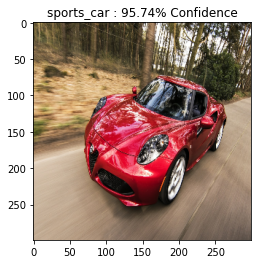

In [10]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

Display the top 5 predictions from the model for the uploaded image.

In [11]:
def get_top_predictions(image_probs):
  top5_probs = np.flip(np.sort(image_probs)[0][-5:])
  top_prob_id = np.argmax(image_probs)
  top5_decoded_probs = tf.keras.applications.imagenet_utils.decode_predictions(
    image_probs, top=5
  )
  x_labels=[top5_decoded_probs[0][idx][1] for idx in range(0, 5)]

  return top5_probs, top_prob_id, x_labels

In [12]:
def display_top_probabilities(x_labels, top5_probs):
  fig = go.Figure(data=[go.Bar(x=x_labels, y=top5_probs,
               hovertext=top5_probs)])
  fig.update_traces(marker_color='rgb(158,202,225)', 
                  marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
  fig.update_layout(title_text='Top 5 Predictions')

  return fig

In [13]:
top5_probs, top_prob_id, x_labels = get_top_predictions(image_probs)

In [14]:
bar_chart_fig = display_top_probabilities(x_labels, top5_probs)
bar_chart_fig.show()

### Adversarial Attack
We are going to create adversarial samples using the **Basic Iterative Method (BIM)** technique. Instead of applying the perturbation in a single step (such as in FGSM), it is applied multiple times with a small step size. The pixel values of intermediate results are clipped after each step to ensure that they are in a neighbourhood of the original image. The following equation summarizes this method:     
Step 0: $adv^x_{0} = x$  
Any other step: $adv^x_{N+1} = x_\epsilon \{adv^x_{N} + \alpha * sign(\nabla{x}J(adv^x_{N},y))\}$  
where $\epsilon$ is the tunable parameter and $\alpha$ is the step size.  
Reporting below also the formula for FGSM as reference:  
$adv_x = x + \epsilon * sign(\nabla{x}J(\theta,x,y))$  


Choose a loss function.

In [15]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

Define a function to generate an adversarial sample starting from the orignal image by applying a basic iterative method.

In [16]:
def basic_iteration_method(decoded_image, label, epochs, loss_object, epsilon,alpha):
  clean_image = decoded_image

  for i in tf.range(epochs):
      # Track gradients
      with tf.GradientTape(watch_accessed_variables=False) as tape:
          # Only gradients w.r.t. X are accumulated, NOT model parameters
          tape.watch(decoded_image)
          prediction = pretrained_model(decoded_image)
          loss = loss_object(label, prediction)
          
          gradients = tape.gradient(loss, decoded_image)
          # Compute perturbation as step size times signum of gradients
          perturbation = alpha * tf.sign(gradients)
          # Update the image by adding perturbation
          decoded_image = decoded_image + perturbation
          # Make sure the image does not leave epsilon L infinity ball around clean_images
          decoded_image = tf.clip_by_value(decoded_image, clean_image - epsilon, clean_image + epsilon)
          # Make sure entries from image remain between 0 and 1
          decoded_image = tf.clip_by_value(decoded_image, 0, 1)

  return decoded_image

Get the input label for the chosen image.

In [17]:
label = tf.one_hot(top_prob_id, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

Set the parameters for the BIM method.

In [18]:
epochs = 40
epsilon = 0.007
alpha = epsilon / 40

Generate an adversarial sample.

In [19]:
adversarial_image = basic_iteration_method(image, label, epochs, loss_object, epsilon, alpha)
save_img('BIM_' + str(epsilon) + '_' + str(alpha) + '.jpg', adversarial_image[0])

Display the generated adversarial image.

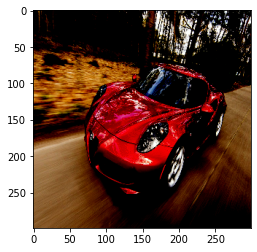

In [20]:
plt.imshow(adversarial_image[0])

Verify which results the model returns trying to classify this adversarial sample.

In [21]:
adv_image_probs = pretrained_model.predict(adversarial_image)

In [22]:
top5_probs, top_prob_id, x_labels = get_top_predictions(adv_image_probs) 

In [24]:
bar_chart_fig = display_top_probabilities(x_labels, top5_probs)
bar_chart_fig.show()